<a href="https://colab.research.google.com/github/sheemambabu/CMPE-258-Deep-Learning/blob/main/Assigment%203/HW_3_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE-258 Deep Learning
## Homework 3
### By,
### Sheema Murugesh Babu (SJSU-ID: 015217176)



Part a) Using pure Numpy to build a 3 layer neural network (with relu nonlinearity - this is different from the  2 layer i have provided in the colab in slide deck) to train on data - pick appropriate number of neurons in each layer and just use relu for non linearity.

# Using pure numpy:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generating sample data: 

In [ ]:
n_samples = 200
input_dimensions = 3
output_dimensions = 2

np.random.seed(123)
X = np.random.uniform(-1, 1, (n_samples, input_dimensions))
print('Samples values of x:', X[:3])

weights_true = np.array([[5, 1, -5], [-1, -8, 1]])
bias_true = np.array([[1], [1]])

y_true = (6 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Samples values of y:', y_true[:3])
print(f'X: {X.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

Samples values of x: [[ 0.39293837 -0.42772133 -0.54629709]
 [ 0.10262954  0.43893794 -0.15378708]
 [ 0.9615284   0.36965948 -0.0381362 ]]
Samples values of y: [[  2.0449307   -4.43461086]
 [  3.4834908  -11.93720698]
 [ 34.88034587 -15.05454554]]
X: (200, 3), weights: (2, 3), bias: (2, 1), y: (200, 2)


# Function plot 3-D data with sklearn TSNE


In [ ]:
def plot_3d(title, X, y, y_pred=None):
  X_tsne = TSNE(n_components = 2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
     ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y_pred, label='y_pred', marker = '^')
  plt.legend()
  plt.show()

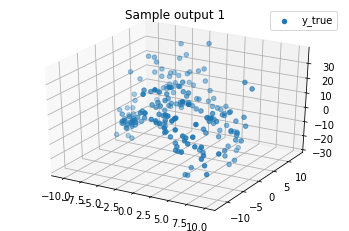

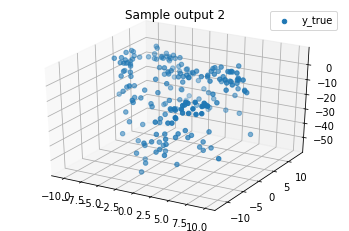

In [ ]:
plot_3d('Sample output 1', X, y_true[:,0])
plot_3d('Sample output 2', X, y_true[:,1])

# Building a neural network from scratch


In [ ]:
# Mean Squared Error

class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient


In [ ]:
# Relu Activation layer

class Relu:
  def __init__(self):
    self.input = np.array([])

  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
  def backward(self, upstr_gradient):
    return (self.input > 0) * upstr_gradient
  
  # No update needed to ReLU members
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

In [ ]:
class Layer:
  def __init__(self, n_input_nodes=1, n_output_nodes=1, activation_func=None):
    self.n_input_nodes = n_input_nodes
    self.n_output_nodes = n_output_nodes

    # Init layer with random weights and bias
    self.weights = np.random.rand(n_input_nodes, n_output_nodes)
    self.bias = np.random.rand((1))
    self.X = np.zeros([n_input_nodes])

    # Setting the activation function
    if activation_func == 'relu':
      self.activation_func = Relu()
    else: 
      self.activation_func = None
  
  def forward(self, X):
    self.X = X.copy()
    self.Z = X @ self.weights + self.bias
    # Passing the output to activation function
    if self.activation_func == None:
      return self.Z 
    else:
      return self.activation_func.forward(self.Z)

  def backward(self, upstr_gradient):
    current_upstr_gradient = upstr_gradient.copy()

    # Performed backpropagation on activation function first before backpropagation on weight and bias gradient.
    if self.activation_func != None:
      current_upstr_gradient = self.activation_func.backward(current_upstr_gradient)
    
    # Computing the gradient of the weights with respect to loss by taking the dot product of upstream gradient with local gradient
    self.dJdW = self.X.T @ current_upstr_gradient
    # Bias is a constant so its derivative is 1 and the dot product of 1 and the upstream gradient is the sum of the gradient
    self.dJdb = current_upstr_gradient.sum()
    # Computing the gradient of input X with repect to loss by taking dot product of upstream gradient with local gradient. 
    # This value is returned because it serves as the new "upstream" gradient in the previous layer
    self.dJdX = current_upstr_gradient @ self.weights.T
    return self.dJdX

  # Updating the weight and bias params with learning rate step size
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{} \nWeights:\n{} \nBias:{}'.format(self.n_input_nodes, self.n_output_nodes, self.activation_func, self.X[:2], 
            self.weights, self.bias)

In [ ]:
class NeuralNetwork_Model:
  def __init__(self, n_inputs=3, n_hidden=[2], n_outputs=2, activation_func=None):
    self.n_inputs = n_inputs
    self.n_hidden = n_hidden
    self.n_outputs = n_outputs

    layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      # Not adding the activation function to last layer because it is a regression problem
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func))

    # Printing the network architecture
    print('Neural Network Architecture:')
    for i, layer in enumerate(self.layers):
      print('---------------------- Layer {} ----------------------'.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    current_output = inputs.copy()
    for l in self.layers:
      current_output = l.forward(current_output)
    return current_output
  
  def backward(self, y_pred, y_true):
    # Starting with the gradient from loss function with repect to prediction
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('MSE: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()

    # Passing dJ/dy to last layer of network and computing gradients at each layer backwards
    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Training loop over number of epochs
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

# Hyperparameters

In [ ]:
# Number of Iterations
epochs = 280

# Learning rate of the algorithm
lr = 0.01

# Input and output size. i.e 3 and 2 relatively
input = X.shape[1]
output = y_true.shape[1]

print(input)
print(output)

3
2


# Training the Neural Network model with ReLU activation function

In [ ]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func='relu')
model.fit(X, y_true, epochs)
y_pred = model.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE with ReLU: {}'.format(err))

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.] 
Weights:
[[0.7013598  0.70758112 0.95993913 0.87670468]
 [0.46805967 0.62590651 0.45718173 0.22294624]
 [0.376677   0.10388423 0.66652712 0.19203014]] 
Bias:[0.47546779]
---------------------- Layer 1 ----------------------
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.] 
Weights:
[[0.9674366  0.03166893 0.15172995]
 [0.29857918 0.94180696 0.9088418 ]
 [0.16200084 0.98111777 0.75074753]
 [0.53997708 0.93170288 0.88060714]] 
Bias:[0.39131649]
---------------------- Layer 2 ----------------------
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.6563432  0.64738515]
 [0.32696819 0.17939017]
 [0.46680988 0.26328104]] 
Bias:[0.35506513]

MSE:  302.27125268949584
MSE:  267.24035205117724
MSE:  248.09665953645774
MSE:  211.9679421629205
MSE:  193.77981863685426
MSE:  196.78803485427514
MSE:  196.43377139030622
MSE:  225.815022087

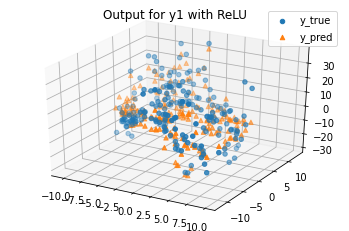

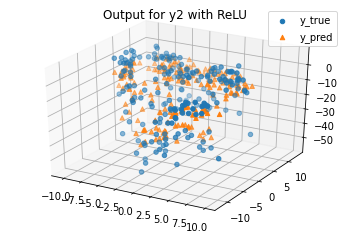

In [ ]:
plot_3d('Output for y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 with ReLU', X, y_true[:,1], y_pred[:,1])

# Training the Neural Network model without ReLU activation function

In [ ]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func=None)
model.fit(X, y_true, epochs)
y_pred = model.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE without ReLU: {}'.format(err))

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.95414397 0.46113787 0.68489147 0.33622989]
 [0.99586108 0.65876761 0.19600947 0.098184  ]
 [0.94318057 0.94477783 0.62132838 0.0169915 ]] 
Bias:[0.22553488]
---------------------- Layer 1 ----------------------
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.80127678 0.87545983 0.45398981]
 [0.36552062 0.27422501 0.11697051]
 [0.11574454 0.9526027  0.80862611]
 [0.16477936 0.20705005 0.65555155]] 
Bias:[0.76466422]
---------------------- Layer 2 ----------------------
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.] 
Weights:
[[0.81031485 0.16333769]
 [0.98412829 0.22780207]
 [0.58941543 0.58761576]] 
Bias:[0.96736189]

MSE:  308.1166458036781
MSE:  286.2423667339684
MSE:  276.62382917543044
MSE:  266.1068682702038
MSE:  245.08238211641103
MSE:  209.40237773192644
MSE:  189.30742835952998
MSE:  186.45185507535

From the above, we can see that the error is larger when ReLU activation is not applied.

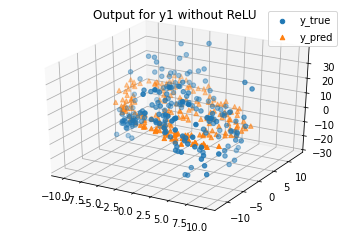

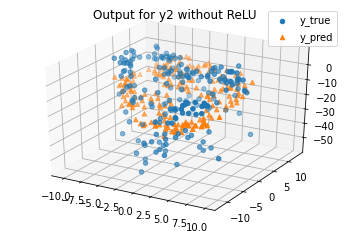

In [ ]:
plot_3d('Output for y1 without ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 without ReLU', X, y_true[:,1], y_pred[:,1])

## References :

1) Class Slides <br>
2) https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9 <br>
3) https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html